In [1]:
import numpy as np
import pandas as pd
import glob
import errno
import os
import random
import spacy
import string
import pickle as pkl
from collections import Counter

import torch
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
def build_vocab(all_tokens):
    # Returns:
    # id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # token2id: dictionary where keys represent tokens and corresponding values represent indices
    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(max_vocab_size))
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token

# convert token to id in the dataset
def token2index_dataset(tokens_data):
    indices_data = []
    for tokens in tokens_data:
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data

class NewsGroupDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list, target_list):
        """
        @param data_list: list of newsgroup tokens 
        @param target_list: list of newsgroup targets 

        """
        self.data_list = data_list
        self.target_list = target_list
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        
        token_idx = self.data_list[key][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        return [token_idx, len(token_idx), label]

def newsgroup_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list = []
    label_list = []
    length_list = []
    #print("collate batch: ", batch[0][0])
    #batch[0][0] = batch[0][0][:MAX_SENTENCE_LENGTH]
    for datum in batch:
        label_list.append(datum[2])
        length_list.append(datum[1])
    # padding
    for datum in batch:
        padded_vec = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[1])), 
                                mode="constant", constant_values=0)
        data_list.append(padded_vec)
    return [torch.from_numpy(np.array(data_list)), torch.LongTensor(length_list), torch.LongTensor(label_list)]

class BagOfWords(nn.Module):
    """
    BagOfWords classification model
    """
    def __init__(self, vocab_size, emb_dim):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        """
        super(BagOfWords, self).__init__()
        # pay attention to padding_idx 
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.linear = nn.Linear(emb_dim,2)
    
    def forward(self, data, length):
        """
        
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        out = self.embed(data)
        out = torch.sum(out, dim=1)
        out /= length.view(length.size()[0],1).expand_as(out).float()
     
        # return logits
        out = self.linear(out.float())
        return out

# Function for testing the model
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data, lengths, labels in loader:
        data_batch, length_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

In [3]:
test_targets = ([1]*12500) + ([0]*12500)
train_split = 10000
train_targets = ([1]*train_split) + ([0]*train_split)
val_targets = ([1]*2500) + ([0]*2500)

In [4]:
# save index 0 for pad and 1 for unk
PAD_IDX = 0
UNK_IDX = 1

max_vocab_size = 20000
MAX_SENTENCE_LENGTH = 400

learning_rate = 0.001
emb_dim = 400

### Tokenize - none

In [5]:
train_none = pkl.load(open("train_none.p", "rb"))
all_train_none = pkl.load(open("all_train_none.p", "rb"))

val_none = pkl.load(open("val_none.p", "rb"))
test_none = pkl.load(open("test_none.p", "rb"))

In [9]:
token2id, id2token = build_vocab(all_train_none)

train_data_indices = token2index_dataset(train_none)
val_data_indices = token2index_dataset(val_none)
test_data_indices = token2index_dataset(test_none)

In [10]:
BATCH_SIZE = 32
train_dataset = NewsGroupDataset(train_data_indices, train_targets)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices, val_targets)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

test_dataset = NewsGroupDataset(test_data_indices, test_targets)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)

model = BagOfWords(len(id2token), emb_dim)

num_epochs = 5 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [11]:
val_acc_none = []
train_acc_none = []

print('Tokenize: none')
for epoch in range(num_epochs):
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()
        # validate every 625 iterations
        if i > 0 and i % 624 == 0:
            # validate
            val_acc = test_model(val_loader, model)
            train_acc = test_model(train_loader, model)
            print('Epoch: [{}/{}], Step: [{}/{}], Train loss: {}, Train acc: {}, Validation Acc: {}'.format( 
                       epoch+1, num_epochs, i+1, len(train_loader), loss, train_acc, val_acc))
            train_acc_none.append(train_acc)
            val_acc_none.append(val_acc)

Tokenize: none
Epoch: [1/5], Step: [625/625], Train loss: 0.3654152750968933, Train acc: 87.175, Validation Acc: 83.54
Epoch: [2/5], Step: [625/625], Train loss: 0.326225221157074, Train acc: 91.745, Validation Acc: 87.26
Epoch: [3/5], Step: [625/625], Train loss: 0.2633203864097595, Train acc: 94.285, Validation Acc: 88.32
Epoch: [4/5], Step: [625/625], Train loss: 0.17276690900325775, Train acc: 95.96, Validation Acc: 88.56
Epoch: [5/5], Step: [625/625], Train loss: 0.1513471007347107, Train acc: 97.39, Validation Acc: 88.7


### Tokenize - lower

In [6]:
train_lower = pkl.load(open("train_lower.p", "rb"))
all_train_lower = pkl.load(open("all_train_lower.p", "rb"))

val_lower = pkl.load(open("val_lower.p", "rb"))
test_lower = pkl.load(open("test_lower.p", "rb"))

In [12]:
token2id, id2token = build_vocab(all_train_lower)

train_data_indices = token2index_dataset(train_lower)
val_data_indices = token2index_dataset(val_lower)
test_data_indices = token2index_dataset(test_lower)

In [13]:
BATCH_SIZE = 32
train_dataset = NewsGroupDataset(train_data_indices, train_targets)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices, val_targets)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

test_dataset = NewsGroupDataset(test_data_indices, test_targets)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)

model = BagOfWords(len(id2token), emb_dim)

num_epochs = 5 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [14]:
val_acc_lower = []
train_acc_lower = []

print('Tokenize: lower case')
for epoch in range(num_epochs):
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()
        # validate every 625 iterations
        if i > 0 and i % 624 == 0:
            # validate
            val_acc = test_model(val_loader, model)
            train_acc = test_model(train_loader, model)
            print('Epoch: [{}/{}], Step: [{}/{}], Train loss: {}, Train acc: {}, Validation Acc: {}'.format( 
                       epoch+1, num_epochs, i+1, len(train_loader), loss, train_acc, val_acc))
            train_acc_lower.append(train_acc)
            val_acc_lower.append(val_acc)

Tokenize: lower case
Epoch: [1/5], Step: [625/625], Train loss: 0.2772720754146576, Train acc: 86.755, Validation Acc: 84.1
Epoch: [2/5], Step: [625/625], Train loss: 0.3637368679046631, Train acc: 91.545, Validation Acc: 87.4
Epoch: [3/5], Step: [625/625], Train loss: 0.20252180099487305, Train acc: 94.18, Validation Acc: 88.46
Epoch: [4/5], Step: [625/625], Train loss: 0.18206924200057983, Train acc: 95.71, Validation Acc: 88.6
Epoch: [5/5], Step: [625/625], Train loss: 0.10633857548236847, Train acc: 96.86, Validation Acc: 88.44


### Tokenize - lower, remove punctuations

In [7]:
train_lp = pkl.load(open("train_data_tokens.p", "rb"))
all_train_lp = pkl.load(open("all_train_tokens.p", "rb"))

val_lp = pkl.load(open("val_data_tokens.p", "rb"))
test_lp = pkl.load(open("test_data_tokens.p", "rb"))

In [23]:
token2id, id2token = build_vocab(all_train_lp)

train_data_indices = token2index_dataset(train_lp)
val_data_indices = token2index_dataset(val_lp)
test_data_indices = token2index_dataset(test_lp)

In [24]:
BATCH_SIZE = 32
train_dataset = NewsGroupDataset(train_data_indices, train_targets)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices, val_targets)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

test_dataset = NewsGroupDataset(test_data_indices, test_targets)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)

model = BagOfWords(len(id2token), emb_dim)

num_epochs = 5 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [17]:
val_acc_lp = []
train_acc_lp = []

print('Tokenize: lower case, remove punctuations')
for epoch in range(num_epochs):
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()
        # validate every 625 iterations
        if i > 0 and i % 624 == 0:
            # validate
            val_acc = test_model(val_loader, model)
            train_acc = test_model(train_loader, model)
            print('Epoch: [{}/{}], Step: [{}/{}], Train loss: {}, Train acc: {}, Validation Acc: {}'.format( 
                       epoch+1, num_epochs, i+1, len(train_loader), loss, train_acc, val_acc))
            train_acc_lp.append(train_acc)
            val_acc_lp.append(val_acc)

Tokenize: lower case, remove punctuations
Epoch: [1/5], Step: [625/625], Train loss: 0.29365330934524536, Train acc: 87.32, Validation Acc: 84.96
Epoch: [2/5], Step: [625/625], Train loss: 0.20181486010551453, Train acc: 92.125, Validation Acc: 87.86
Epoch: [3/5], Step: [625/625], Train loss: 0.12869715690612793, Train acc: 94.42, Validation Acc: 88.82
Epoch: [4/5], Step: [625/625], Train loss: 0.12102694809436798, Train acc: 96.225, Validation Acc: 89.32
Epoch: [5/5], Step: [625/625], Train loss: 0.07878977060317993, Train acc: 97.33, Validation Acc: 88.88


### Tokenize - lower, remove punctuations, stopwords

In [8]:
train_lpsw = pkl.load(open("train_lowerpunc_stopw.p", "rb"))
all_train_lpsw = pkl.load(open("all_train_lowerpunc_stopw.p", "rb"))

val_lpsw = pkl.load(open("val_lowerpunc_stopw.p", "rb"))
test_lpsw = pkl.load(open("test_lowerpunc_stopw.p", "rb"))

In [18]:
token2id, id2token = build_vocab(all_train_lpsw)

train_data_indices = token2index_dataset(train_lpsw)
val_data_indices = token2index_dataset(val_lpsw)
test_data_indices = token2index_dataset(test_lpsw)

In [19]:
BATCH_SIZE = 32
train_dataset = NewsGroupDataset(train_data_indices, train_targets)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices, val_targets)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

test_dataset = NewsGroupDataset(test_data_indices, test_targets)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)

model = BagOfWords(len(id2token), emb_dim)

num_epochs = 5 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [20]:
val_acc_lpsw = []
train_acc_lpsw = []

print('Tokenize: lower case, remove punctuations, remove stopwords')
for epoch in range(num_epochs):
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()
        # validate every 625 iterations
        if i > 0 and i % 624 == 0:
            # validate
            val_acc = test_model(val_loader, model)
            train_acc = test_model(train_loader, model)
            print('Epoch: [{}/{}], Step: [{}/{}], Train loss: {}, Train acc: {}, Validation Acc: {}'.format( 
                       epoch+1, num_epochs, i+1, len(train_loader), loss, train_acc, val_acc))
            train_acc_lpsw.append(train_acc)
            val_acc_lpsw.append(val_acc)

Tokenize: lower case, remove punctuations, remove stopwords
Epoch: [1/5], Step: [625/625], Train loss: 0.3604917824268341, Train acc: 89.805, Validation Acc: 86.8
Epoch: [2/5], Step: [625/625], Train loss: 0.34660711884498596, Train acc: 94.055, Validation Acc: 89.0
Epoch: [3/5], Step: [625/625], Train loss: 0.14898227155208588, Train acc: 96.475, Validation Acc: 89.14
Epoch: [4/5], Step: [625/625], Train loss: 0.07438864558935165, Train acc: 97.925, Validation Acc: 88.84
Epoch: [5/5], Step: [625/625], Train loss: 0.04629206657409668, Train acc: 98.95, Validation Acc: 88.78


## Plot accuracy

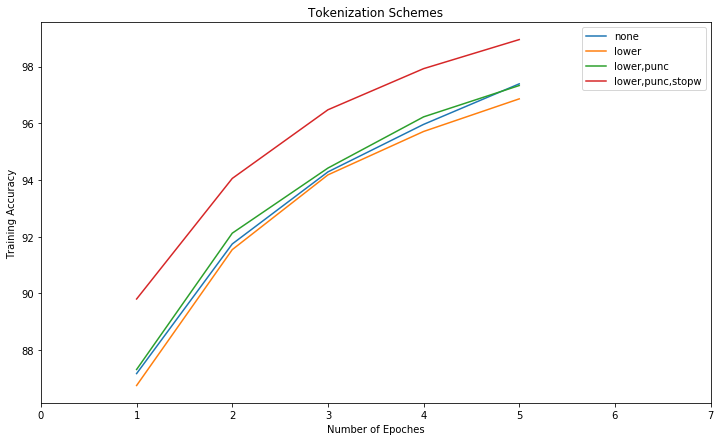

In [21]:
fig = plt.figure(1,figsize = (12,7)) 
ax = plt.subplot(111)
x_rge = list(range(1,6))

plt.plot(x_rge,train_acc_none,label="none")
plt.plot(x_rge,train_acc_lower,label="lower")
plt.plot(x_rge,train_acc_lp,label="lower,punc")
plt.plot(x_rge,train_acc_lpsw,label="lower,punc,stopw")

plt.xlim(0,7)
plt.legend(loc=1)
plt.xlabel("Number of Epoches")
plt.ylabel("Training Accuracy")
plt.title("Tokenization Schemes")
plt.show()

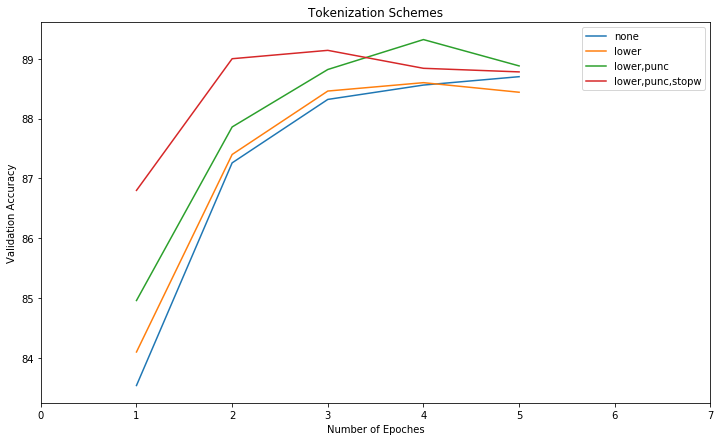

In [22]:
fig = plt.figure(2,figsize = (12,7)) 
ax = plt.subplot(111)
x_rge = list(range(1,6))

plt.plot(x_rge,val_acc_none,label="none")
plt.plot(x_rge,val_acc_lower,label="lower")
plt.plot(x_rge,val_acc_lp,label="lower,punc")
plt.plot(x_rge,val_acc_lpsw,label="lower,punc,stopw")

plt.xlim(0,7)
plt.legend(loc=1)
plt.xlabel("Number of Epoches")
plt.ylabel("Validation Accuracy")
plt.title("Tokenization Schemes")
plt.show()

## Correct/Incorrect Predictions

In [23]:
token2id, id2token = build_vocab(all_train_lp)

train_data_indices = token2index_dataset(train_lp)
val_data_indices = token2index_dataset(val_lp)
test_data_indices = token2index_dataset(test_lp)

In [38]:
BATCH_SIZE = 32
train_dataset = NewsGroupDataset(train_data_indices, train_targets)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices, val_targets)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)

test_dataset = NewsGroupDataset(test_data_indices, test_targets)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)

model = BagOfWords(len(id2token), emb_dim)

num_epochs = 5 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [39]:
print('Tokenize: lower case, remove punctuations')
for epoch in range(num_epochs):
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()
        # validate every 625 iterations
        if i > 0 and i % 624 == 0:
            # validate
            val_acc = test_model(val_loader, model)
            train_acc = test_model(train_loader, model)
            print('Epoch: [{}/{}], Step: [{}/{}], Train loss: {}, Train acc: {}, Validation Acc: {}'.format( 
                       epoch+1, num_epochs, i+1, len(train_loader), loss, train_acc, val_acc))

Tokenize: lower case, remove punctuations
Epoch: [1/5], Step: [625/625], Train loss: 0.49076271057128906, Train acc: 87.385, Validation Acc: 84.72
Epoch: [2/5], Step: [625/625], Train loss: 0.44643861055374146, Train acc: 92.14, Validation Acc: 87.7
Epoch: [3/5], Step: [625/625], Train loss: 0.17615312337875366, Train acc: 94.34, Validation Acc: 88.3
Epoch: [4/5], Step: [625/625], Train loss: 0.1878061592578888, Train acc: 95.93, Validation Acc: 89.02
Epoch: [5/5], Step: [625/625], Train loss: 0.11846697330474854, Train acc: 97.345, Validation Acc: 88.94


In [40]:
def get_prediction(loader, model):
    index_arr = []
    model.eval()
    for data, lengths, labels in loader:
        data_batch, length_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        equal_label = torch.eq(predicted.view_as(labels),labels)
        index_arr.append(np.argwhere(equal_label.numpy()))
    return index_arr

In [41]:
ind = get_prediction(val_loader,model)

In [44]:
for i in range(0,len(ind)):
    print(i,len(ind[i]))

0 31
1 26
2 29
3 29
4 25
5 28
6 29
7 25
8 28
9 29
10 31
11 28
12 27
13 29
14 29
15 31
16 25
17 26
18 25
19 28
20 29
21 30
22 29
23 29
24 26
25 27
26 25
27 28
28 26
29 31
30 30
31 27
32 27
33 26
34 19
35 29
36 29
37 26
38 24
39 27
40 30
41 25
42 30
43 30
44 28
45 27
46 27
47 28
48 28
49 27
50 29
51 24
52 30
53 28
54 26
55 27
56 24
57 26
58 28
59 26
60 28
61 28
62 28
63 29
64 29
65 24
66 27
67 29
68 28
69 28
70 28
71 30
72 30
73 30
74 30
75 29
76 28
77 25
78 29
79 30
80 28
81 31
82 28
83 26
84 28
85 29
86 29
87 30
88 25
89 32
90 32
91 29
92 28
93 31
94 31
95 26
96 28
97 28
98 30
99 31
100 30
101 26
102 29
103 31
104 29
105 30
106 30
107 32
108 31
109 30
110 30
111 30
112 27
113 29
114 29
115 29
116 29
117 29
118 29
119 29
120 28
121 30
122 31
123 28
124 29
125 28
126 29
127 29
128 25
129 28
130 30
131 32
132 30
133 30
134 31
135 26
136 28
137 30
138 30
139 28
140 31
141 31
142 30
143 32
144 32
145 29
146 27
147 32
148 30
149 31
150 26
151 30
152 29
153 30
154 28
155 27
156 7


In [66]:
ind[156] #4994

array([[0],
       [1],
       [3],
       [4],
       [5],
       [6],
       [7]])

In [59]:
len(ind[1]) #37,38,31+11=44,31+22=53

26

In [48]:
def load_data(files):
    data = []
    for name in files:
        try:
            with open(name) as f:
                for line in f:
                    data.append(line)
        except IOError as exc:
            if exc.errno != errno.EISDIR:
                raise
    return data

In [49]:
path = os.getcwd()+'/aclImdb/train/pos/*.txt'
files = glob.glob(path)
train_pos_data = load_data(files)

path = os.getcwd()+'/aclImdb/train/neg/*.txt'
files = glob.glob(path)
train_neg_data = load_data(files)

train_split = 10000
train_data = train_pos_data[:train_split] + train_neg_data[:train_split]
train_targets = ([1]*train_split) + ([0]*train_split)

val_data = train_pos_data[train_split:] + train_neg_data[train_split:]
val_targets = ([1]*(len(train_pos_data)-train_split)) + ([0]*(len(train_pos_data)-train_split))

In [50]:
val_data[37]

"I went to see Vanilla Sky with a huge, huge, huge!!..Tom Cruise fan, my extremely cynical brother and my girlfriend ... what can I say .. I was totally blown away by the movie and especially TC's performance, I thought it was a very moving film and it was not at all what I was expecting.<br /><br />I had read the reviews and had decided not to go and see it, I am so pleased that I was 'coerced 'into seeing it. The strange thing is I cannot say why, all I can say is that I found it totally involving and could not stop thinking about it the next day. As to what I felt about the film, all I can say about is, ITS NOT THE STORYLINE (fantasy, psychodrama, whatever) its about the people and the events that shape their life and how small events, like getting into a car can change everything......<br /><br />As to what the critics wrote, yes maybe the original was a stunning 2nd film for Alejandro Amenábar , but this was a totally different interpretation of the subject, and by no means a narc

In [56]:
val_targets[37]

1

In [51]:
val_data[44]

'This is the kind of film for a snowy Sunday afternoon when the rest of the world can go ahead with its own business as you descend into a big arm-chair and mellow for a couple of hours. Wonderful performances from Cher and Nicolas Cage (as always) gently row the plot along. There are no rapids to cross, no dangerous waters, just a warm and witty paddle through New York life at its best. A family film in every sense and one that deserves the praise it received.'

In [54]:
val_targets[44]

1

In [67]:
val_data[4994]

'Richard Farnsworth is one of my favorite actors. He usually gives solid performances, such as in The Straight Story, and The Grey Fox. He also does fairly well here, but the rest of the film suffers from a low budget, poor writing, and so-so photography. The Miller-Movie formula gives it a 4. Richard gets a 5.'

In [68]:
val_targets[4994]

0

### correct prediction

In [60]:
val_data[31]

"This Columbo episode is probably noted more for the director, Steven Spielberg, as one of his early films. It should be looked at for Jack Cassidy's role as the murderer who kills his partner in writing to maintain his lifestyle. Jack Cassidy would appear in a later Columbo. After all, Columbo meets his match in Jack Cassidy's character. He is a mystery writer who plots to perform the perfect murder. After his first murder, his next victim would be the annoying general store owner/widow who would blackmail him for money. Rather than losing more money, he kills her. It is very entertaining to watch Cassidy and Falk as always. Falk's familiarity as Columbo makes him watchable after viewing this episode repeatedly over the years. What television today forgets about the success of years is that people will want to watch the shows again and again if they like the characters. It's not about who does it, how and why, it the familiarness of Columbo and his likability which scores high with vi

In [61]:
val_targets[31]

1

In [62]:
val_data[40]

"I know many people have a special fondness for the Alistair Sim version of Dickens' story, but for me, this 1984 version is the one to beat. My wife and I own a copy of this film on VHS, and we watch it together every Christmas Eve. I often remark that we could watch it on Halloween too, because it's a very creepy ghost story.<br /><br />Scott--typecast as Scrooge--is shudderingly mean and nasty, making his transformation all the more miraculous and moving. I think it's up there with his performance in Patton. The spirits are all effective, each one creepier than the last. Watching the dark, floating, skeletal form of the Spirit of Christmas Yet to Come sends shivers down my spine every year. And what a supporting cast! David Warner, in particular, is in top form as Bob Cratchit, as is Susannah York as his wife. <br /><br />I seem to recall that this version sticks closer to the original story than most others--but I may be mistaken, as it's been several years since I read it. Regardl

In [63]:
val_targets[40]

1

In [69]:
val_data[4999]

'Not that I dislike childrens movies, but this was a tearjerker with few redeeming qualities. M.J. Fox was the perfect voice for Stuart and the rest of the talent was wasted. Hugh Laurie can be amazingly funny, but is not given the chance in this movie. It´s sugar-coated sugar and would hardly appeal to anyone over 7 years of age. See Toy Story, Monsters Inc. or Shrek instead. 3/10'

In [70]:
val_targets[4999]

0

In [77]:
val_data[4997]


'Oh, those Italians! Assuming that movies about aristocrats with weird fetishes, castles drowned in gothic atmosphere, and back-stabbing relatives trying to get their hands on an inheritance are inherently interesting to all! If you\'ve seen one film of this type, you\'ve basically seen them all (the MST3K favorite "Screaming Skull" fits the mold, too)...and "The Night Evelyn Came Out of the Grave" is formulaic, by-the-numbers, and dull as hell. Even the luscious Erika Blanc is put to waste here.<br /><br />zero/10<br /><br />'

In [78]:
val_targets[4997]

0

## Test Performance

In [71]:
test_acc = test_model(test_loader,model)

In [72]:
test_acc

87.288